In [50]:
from OwnGenetical import geneticalgorithm as ga

In [53]:
def Func(x):
    return np.sum(x)

def Func2(x):
    return -np.sum(x)

varbound = np.array([[-10,10]] * 3)

algorithm_param = {'max_num_iteration' : 100,\
                   'population_size' : 5,\
                   'mutation_probability' : 0.4,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type' : 'uniform',\
                   'max_iteration_without_improv' : 1_000_000}

GA_model = ga(function = Func,\
                            secondfunc = Func2, \
            dimension = 3,\
            variable_type = 'real',\
            variable_boundaries = varbound,\
            algorithm_parameters = algorithm_param,
            function_timeout = 1_0,
            convergence_curve = False)

GA_model.run()


 The best solution found:                                                                           
 [-9.76387836 -9.99854179 -9.85109855]

 Objective function:
 -29.613518696443975


Text(0.5, 1.0, '')

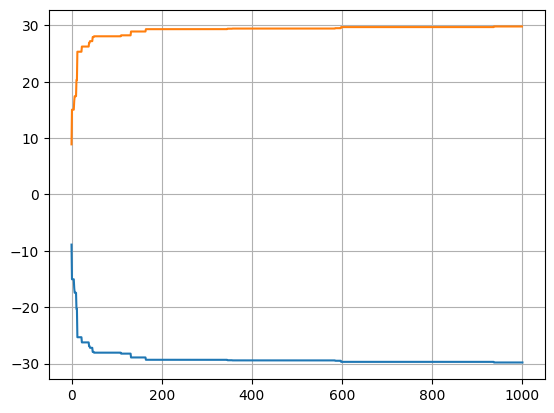

In [52]:
plt.plot(GA_model.report)
plt.plot(GA_model.reportsecond)
plt.grid()
plt.title("")

#plt.savefig("Borrarya.png");
#plt.clf()